# Exercise 1: Web Scraping + Coding Best Practices

In [62]:
# ! pip install beautifulsoup4

In [1]:
from bs4 import BeautifulSoup
import requests
import re
import string
import pandas as pd

In [12]:
def process_text(text):
    """Function to remove escape sequences from the text"""
    replacements = {
        '\xa0': ' ',  # non-breaking space
        '\n': ' ',   # newline
        '\t': ' ',   # tab
        '\r': '',    # carriage return
        '&amp;': '&',  # & symbol
        '&gt;': '>',   # > symbol
        '&lt;': '<',   # < symbol
        '&#39;': "'",  # ' symbol
        '&quot;': '"'  # " symbol
    }
    # Replacing sequence with given symbols in the replacement dict
    for seq, replacement in replacements.items():
        text = text.replace(seq, replacement)
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text#.lower()

def process_class_page(page_link, year):
    """
    Utility function to process each year's Alumini Page and extract name, role and company info
    args:
        page_link: link of each year page 
        year : year 
    output:
        df : dataframe containing alum_name, role and company info 
    """
    # Get request on the page link
    response = requests.get(page_link)
    response.raise_for_status()
    
    # Parsing the html content using beautiful soup
    soup = BeautifulSoup(response.text, 'html.parser')
    pattern_outer = re.compile(r'faculty cf')  # Replace 'outer_class_pattern' with your regex pattern for the outer div
    pattern_inner = re.compile(r'faculty-info')  # Replace 'inner_class_pattern' with your regex pattern for the inner div

    outer_divs = soup.find_all('div', class_=pattern_outer)
    result = []
    for outer_div in outer_divs:
        inner_divs = outer_div.find_all('div', class_=pattern_inner)
        for inner_div in inner_divs:
            alumni_name = inner_div.find('h3').get_text(strip=True)

            # Extract role and company
            try:
                details_div = inner_div.find('div', class_='student-alumni-details')
                details_text = process_text(details_div.get_text())
                role, company = details_text.split(' at ',1)
                role = role.strip()
                company = company.strip()
            except AttributeError:
                # Handling the case where role and company name is not found
                role , company = None, None
            except Exception as e:
                # Handling the below cases manually 
                """
                2021 Sara Ho
                data engineer rad ai

                2020 Luping (Rachel) Zhao
                data scientist tiktok

                2015 James Tarlow
                data science  product and practice development

                2013 Isaac Lo
                big data student in the bay area
                """
                role = ' '.join(details_text.split(' ')[:2])
                company = ' '.join(details_text.split(' ')[2:])
            data = {
                "alumni_name": alumni_name,
                "Role": role,
                "Company": company
            }
            result.append(data)
    df = pd.DataFrame(result)
    df['class'] = [year]*df.shape[0]
    return df

In [13]:
def get_alumini_database(web_url, start_year=2013 , end_year=2022):
    """
    Master function to fetch alumini information from base link from start_year to end_year
    args:
        web_url: base_link of the website
        start_year : start year for the database
        end_year : end year of the database
    output:
        alumini_df: alumini database containing "alumni_name", "Role", "Company", "class"
    """
    response = requests.get(web_url)
    response.raise_for_status()  # Will raise an exception for HTTP errors

    # Parse the webpage content with BeautifulSoup
    soup = BeautifulSoup(response.text, 'html.parser')
    year_list = [ year for year in range(start_year, end_year+1)]
    pattern = re.compile(r'Class of (' + '|'.join(map(str, year_list)) + r')')
    class_of_a_tags = soup.find_all('a', title=pattern)

    # Loop through the filtered <a> tags and print them
    alumini_df = None
    # Fetching each year data and getting the dataframe for that
    for a_tag in class_of_a_tags:
        class_link = base_link + a_tag['href']
        year = a_tag['title'].split(' ')[-1]
        class_df = process_class_page(page_link=class_link, year=year)
        alumini_df = pd.concat([class_df,alumini_df])
    return alumini_df
    

In [14]:
base_link = 'https://www.mccormick.northwestern.edu/machine-learning-data-science/people/alumni/'
alumini_df = get_alumini_database(base_link)

In [15]:
alumini_df.head()

,alumni_name,Role,Company,class
0,Scott Albrecht,Senior Manager Data Science,Grainger,2013
1,Yoojong Bang,Principal Data Scientist,Intent Media Inc,2013
2,Shawna Baskin,Senior Manager Tabletop Analytics,Wizards of the Coast,2013
3,William Chiu,Vice President Head of Statistical Modeling,First Republic Bank,2013
4,David Cooperberg,Senior Product Manager,Alteryx,2013


In [21]:
# Correcting mapping to correct the company names
correction_mapper = {
    "Aetna a CVS Health Company" : "Aetna",
    "Aventrix and Solution Leader at C3ai" : "C3ai",
    "LinkedIn China" : "LinkedIn",
    "ABC Supply  TA  Analytics for Big Data at Northwestern University MSiA Program" : "ABC Supply Co Inc",
    "Coupa Software  Teaching Assistant for MSiA program at Northwestern University" : "Coupa Software",
    "Blue Cross Blue Shield of Illinois Montana New Mexico Oklahoma  Texas" : "Blue Cross Blue Shield",
    "Deloitte Consulting" : "Deloitte",
    "8451°" : "8451", 
    "W W Grainger": "Grainger"
}

In [20]:
# Applying Correction mapper to alumini_df
alumini_df.Company = alumini_df.Company.apply(lambda x : correction_mapper.get(x, x))
alumini_df.head()

,alumni_name,Role,Company,class
0,Scott Albrecht,Senior Manager Data Science,Grainger,2013
1,Yoojong Bang,Principal Data Scientist,Intent Media Inc,2013
2,Shawna Baskin,Senior Manager Tabletop Analytics,Wizards of the Coast,2013
3,William Chiu,Vice President Head of Statistical Modeling,First Republic Bank,2013
4,David Cooperberg,Senior Product Manager,Alteryx,2013


In [27]:
top5Companies = alumini_df.groupby('Company')['alumni_name'].count().sort_values(ascending=False).reset_index()[:5]
top5Companies

,Company,alumni_name
0,TransUnion,15
1,Facebook,13
2,Meta,13
3,Amazon,11
4,Coupa Software,9


# Exercise 2: API
## Write a Python program that gathers, summarizes and plots weather data

In [34]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import datetime

API_KEY = "18f6fbef70b24ffc9dd153635233010"

## Get one month of historical temperature data for 20 distinct locations.

In [35]:
def get_past_dates(num_days):
    """
    Given num_days, the function will fetch past 30 days dates starting from current date
    """
    assert num_days > 0, f"Number of days can not be zero"
    dates = []
    current_date = datetime.date.today()
    dates.append(current_date)
    for i in range(num_days-1):
        past_date = current_date - datetime.timedelta(days=i+1)
        dates.append(past_date)
    return dates


def get_weather_data(api_key, location, curr_date):
    """
    Utility Function to get weather data for the given location and a date
    args:
        api_key : API key 
        location : name of the location for which we have to fetch the weather data
        curr_date : date for which we have to fetch the weather data
    output:
        temperatures: list containing maxTemp, minTemp, AvgTemp in degree celsius
    """
    endpoint = f"https://api.worldweatheronline.com/premium/v1/past-weather.ashx"
    params = {
        "key": api_key,
        "q": location,
        "format": "json",
        "date":  curr_date,
        "tp": 24  # daily data
    }
    response = requests.get(endpoint, params=params)
    data = response.json().get('data').get('weather')[0]
    temperatures = [data['maxtempC'], data['mintempC'], data['avgtempC']]
    return temperatures

def get_past_n_days_data(num_days, location):
    """
    master function to fetch past "n" days of weather data for a location
    
    Logic Used:
        - find min, max and avg temperature of each day
        - max temp for n days = max(list of max temp)
        - min temp for n days = min(list of min temp)
        - avg temp for n days = avg(list of avg temp)
    returns:
        return_dict: containing avg, max and min temp for a location for n days
        df_loc : raw dataframe for each n day
    """
    # fetch dates for past n days
    dates = get_past_dates(num_days)
    df_loc = pd.DataFrame(columns=['date','maxTempC', 'minTempC', 'avgTempC'])
    max_temp_list = []
    min_temp_list = []
    avg_temp_list = []
    # Fetching weather info for each date
    for date in dates:
        temp_data = get_weather_data(API_KEY, location, date)
        max_temp_list.append(float(temp_data[0]))
        min_temp_list.append(float(temp_data[1]))
        avg_temp_list.append(float(temp_data[2]))
    
    df_loc['date'] = dates
    df_loc['maxTempC'] = max_temp_list
    df_loc['minTempC'] = min_temp_list
    df_loc['avgTempC'] = avg_temp_list
    
    return_dict = {
        "maxTempC" : df_loc['maxTempC'].max(),
        "minTempC" : df_loc['minTempC'].min(),
        "avgTempC" : df_loc['avgTempC'].mean() 
    }
    
    return return_dict, df_loc

In [36]:
NUM_DAYS = 30
locations = ["London", "Paris", "New York", "Los Angeles", "Tokyo", 
                 "Sydney", "Moscow", "Dubai", "Rome", "Toronto",
                 "Mumbai", "Singapore", "Rio de Janeiro", "Beijing", 
                 "Cairo", "Cape Town", "Mexico City", "Madrid", "Berlin", "Hong Kong"]


summary = {"Location": [], "Min Temp (C)": [], "Mean Temp (C)": [], "Max Temp (C)": []}
    
for location in locations:
    temp_data, df_loc = get_past_n_days_data(NUM_DAYS, location)
    summary["Location"].append(location)
    summary["Min Temp (C)"].append(temp_data.get('minTempC'))
    summary["Mean Temp (C)"].append(temp_data.get('avgTempC'))
    summary["Max Temp (C)"].append(temp_data.get('maxTempC'))

df = pd.DataFrame(summary)
print(df)

          Location  Min Temp (C)  Mean Temp (C)  Max Temp (C)
0           London           7.0      12.666667          24.0
1            Paris           6.0      14.433333          28.0
2         New York           1.0      13.333333          24.0
3      Los Angeles          13.0      21.266667          38.0
4            Tokyo          14.0      19.833333          25.0
5           Sydney          11.0      17.733333          30.0
6           Moscow          -3.0       4.566667          14.0
7            Dubai          28.0      30.433333          33.0
8             Rome          15.0      20.500000          25.0
9          Toronto          -1.0      10.166667          21.0
10          Mumbai          23.0      28.833333          36.0
11       Singapore          26.0      28.366667          32.0
12  Rio de Janeiro          19.0      23.100000          30.0
13         Beijing           4.0      16.633333          27.0
14           Cairo          20.0      25.466667          34.0
15      

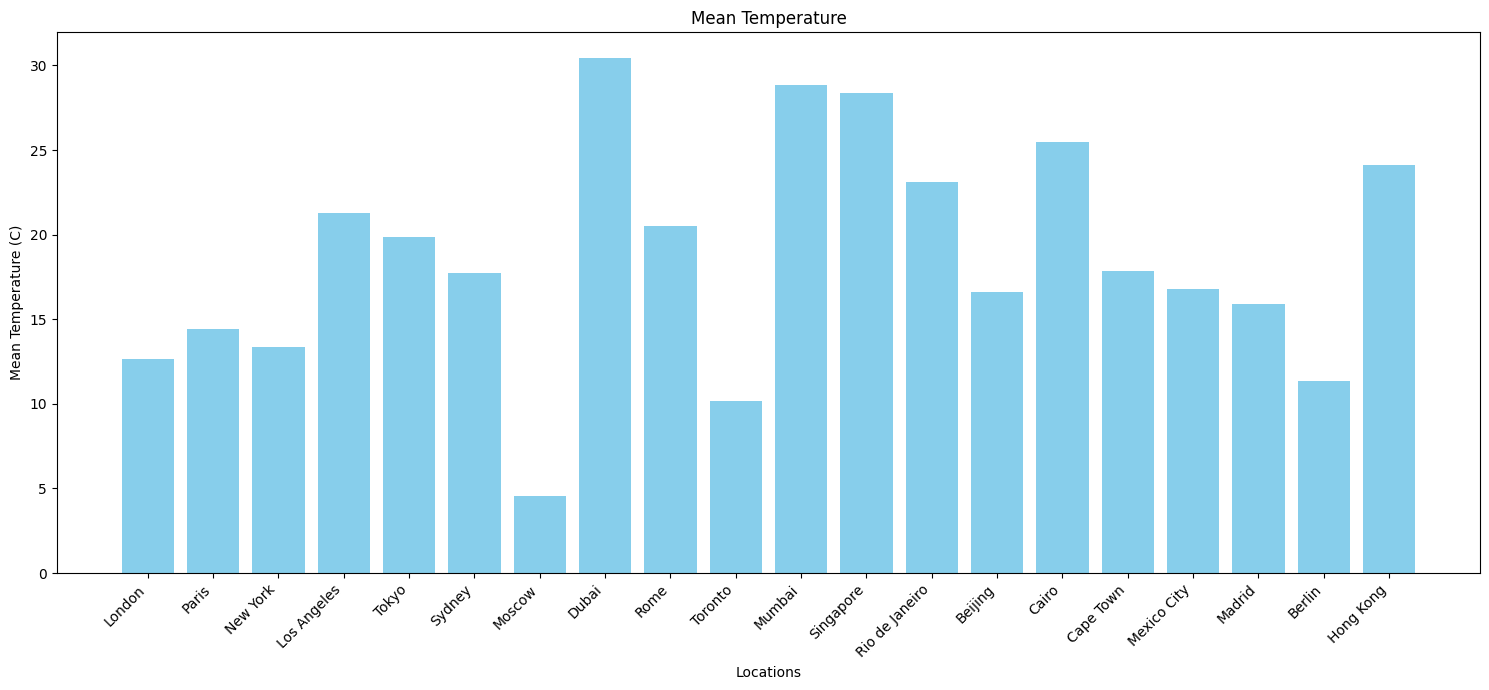

In [37]:
# Plotting the data
plt.figure(figsize=(15,7))
plt.bar(df["Location"], df["Mean Temp (C)"], color='skyblue')
plt.xlabel("Locations")
plt.ylabel("Mean Temperature (C)")
plt.title(f"Mean Temperature")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()